---
## Step 1: Setup and Data Collection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from massive import RESTClient
from scipy import linalg
from datetime import datetime
import warnings

from __future__ import annotations
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modules.eigen import get_event_sequence, classify_transition, PhaseThresholds
from modules.plot_code import set_plot_style

set_plot_style()

In [ ]:
from modules.config import SP500_TICKERS, START_DATE, END_DATE, EPOCH_SIZE, SHIFT

In [3]:
def fetch_data(tickers, start_date, end_date):
    print(f"Fetching {len(tickers)} stocks from {start_date} to {end_date}...")
    
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=True,
        auto_adjust=True
    )['Close']
    
    data = data.ffill().bfill()
    data = data.dropna(axis=1)
    data = data.dropna(axis=0)

    print(f"Final: {data.shape[0]} trading days, {data.shape[1]} stocks")
    return data

# Fetch data
prices = fetch_data(SP500_TICKERS, START_DATE, END_DATE)
N_STOCKS = prices.shape[1]
print(f"\nN = {N_STOCKS} stocks")

Fetching 166 stocks from 1985-01-02 to 2024-12-31...


[*******               14%                       ]  23 of 166 completed$IPG: possibly delisted; no price data found  (1d 1985-01-02 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")
[*********************100%***********************]  166 of 166 completed

1 Failed download:
['IPG']: possibly delisted; no price data found  (1d 1985-01-02 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")


Final: 10079 trading days, 165 stocks

N = 165 stocks


---
## Step 2: Core Functions (Paper's Methodology)

Key equations from the paper:
- Returns: $r_i(\tau) = \ln P_i(\tau) - \ln P_i(\tau - \Delta)$
- Matrix A: $a_{i,j} = |C_{i,j}|^2$ (to ensure Perron-Frobenius)
- Eigen-centrality: $A|p\rangle = \lambda_1 |p\rangle$ with $\sum_i p_i = 1$
- Eigen-entropy: $H = -\sum_{i=1}^{N} p_i \ln p_i$

In [4]:
from modules.data_prep import compute_log_returns, compute_correlation_matrix, correlation_to_A_matrix
from modules.eigen import compute_eigen_centrality, compute_entropy
from modules.eigen import decompose_correlation_matrix, compute_three_entropies

---
## Step 3: Single Epoch Demonstration

In [5]:
# Compute returns
returns = compute_log_returns(prices)
print(f"Returns shape: {returns.shape}")

# Single epoch example
sample_returns = returns.iloc[:EPOCH_SIZE].values
C = compute_correlation_matrix(sample_returns)

print(f"\nCorrelation matrix shape: {C.shape}")
print(f"Mean correlation: {C[np.triu_indices(len(C), k=1)].mean():.4f}")

Returns shape: (10078, 165)

Correlation matrix shape: (165, 165)
Mean correlation: 0.1229


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
# Compute three entropies for single epoch
C = (C + C.T) / 2  
np.fill_diagonal(C, 1.0)
H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
ratio = H_GR / H_M

# Maximum entropy (Wishart/WOE limit)
H_max = np.log(C.shape[0])

print(f"N = {N_STOCKS} stocks")
print(f"\nEntropies:")
print(f"  H (full):        {H:.4f}")
print(f"  H_M (market):    {H_M:.4f}")
print(f"  H_GR (group-random): {H_GR:.4f}")
print(f"  H_max (ln N):    {H_max:.4f}")
print(f"\nPhase space coordinates:")
print(f"  |H - H_M|:  {np.abs(H - H_M):.4f}")
print(f"  |H - H_GR|: {np.abs(H - H_GR):.4f}")

lambda1 = eigenvalues[0]  
print(f"Largest eigenvalue (λ₁) = {lambda1:.2f} (MP bound: {(1 + np.sqrt(len(C)/EPOCH_SIZE))**2:.2f})")

N = 165 stocks

Entropies:
  H (full):        4.9097
  H_M (market):    4.6995
  H_GR (group-random): 5.0455
  H_max (ln N):    5.1059

Phase space coordinates:
  |H - H_M|:  0.2102
  |H - H_GR|: 0.1358
Largest eigenvalue (λ₁) = 29.10 (MP bound: 9.19)


c:\Users\andre\OneDrive\Desktop\project stuff 1\modules\plot_code.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


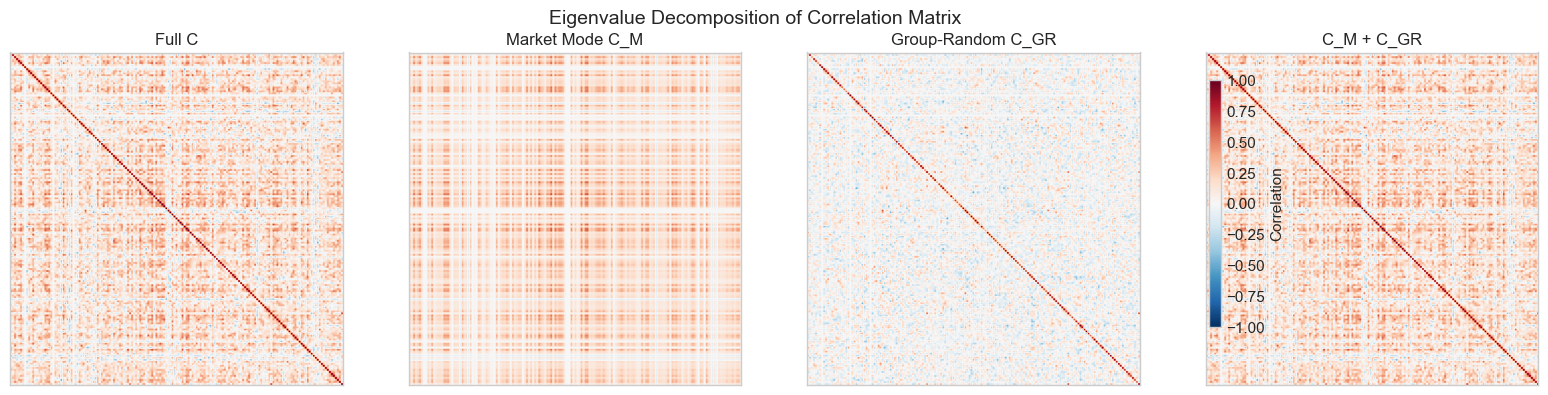

In [7]:
from modules.plot_code import plot_correlation_decomposition

C_M, C_GR, _, _ = decompose_correlation_matrix(C)
plot_correlation_decomposition(C, C_M, C_GR,)

c:\Users\andre\OneDrive\Desktop\project stuff 1\modules\plot_code.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


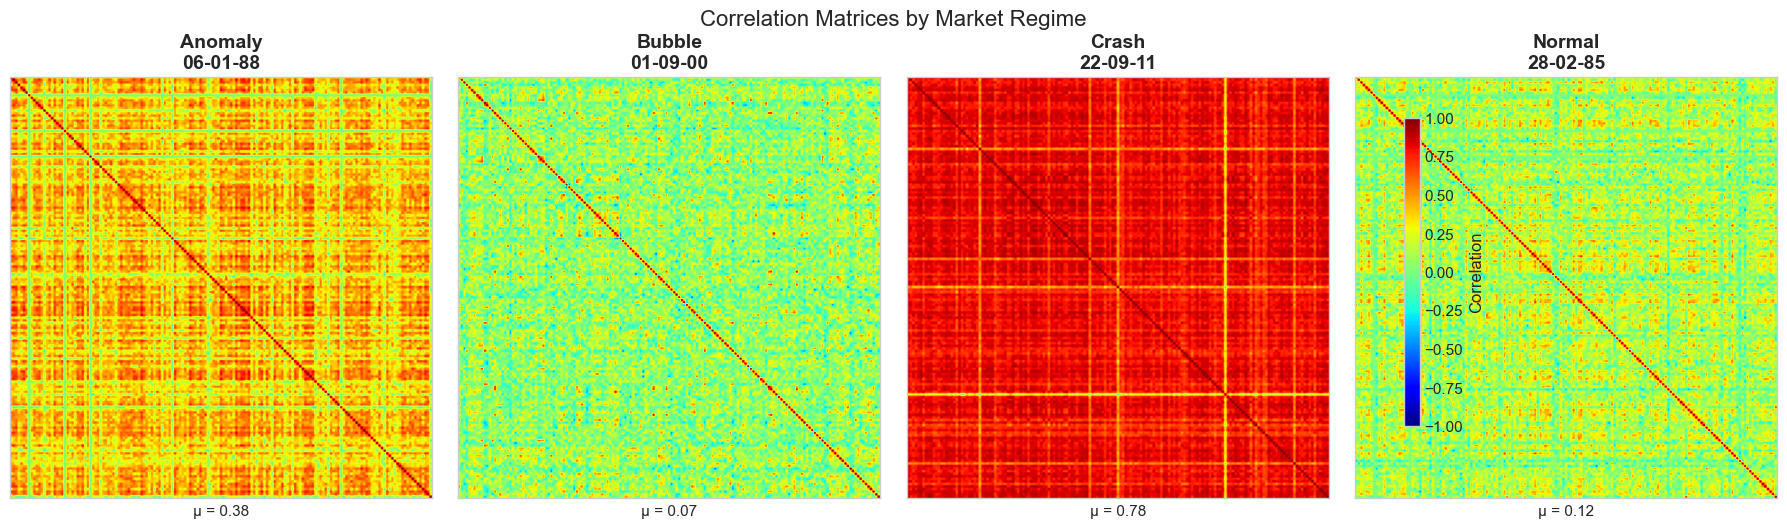

In [8]:
from modules.data_prep import get_correlation_for_date
from modules.plot_code import plot_regime_correlation_matrices
from modules.data_prep import compute_correlation_matrix 

regime_examples = {
    'Anomaly': '1988-01-06',
    'Bubble': '2000-09-01',
    'Crash': '2011-09-22',
    'Normal': '1985-02-28',
}

plot_regime_correlation_matrices(
    returns,
    regime_examples,
    EPOCH_SIZE,
    get_correlation_for_date,
    compute_correlation_matrix)


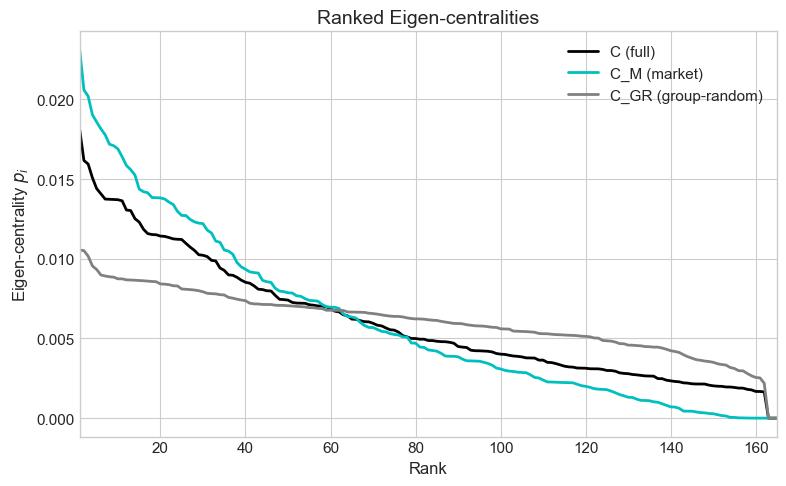

In [9]:
from modules.plot_code import plot_ranked_eigen_centralities
from modules.data_prep import correlation_to_A_matrix
from modules.eigen import compute_eigen_centrality

plot_ranked_eigen_centralities(
    C, C_M, C_GR,
    correlation_to_A_matrix,
    compute_eigen_centrality)


---
## Step 4: Rolling Window Analysis

In [10]:
from modules.eigen import rolling_window_analysis

In [11]:
results = rolling_window_analysis(
    returns,
    epoch_size=EPOCH_SIZE,
    shift=SHIFT)

results.head(10)


date         H       H_M      H_GR     H_max  H_minus_HM  H_minus_HGR  \
0 1985-02-28  4.909706  4.699529  5.045545  5.105945    0.210177    -0.135839   
1 1985-03-28  4.937836  4.687854  5.048249  5.105945    0.249982    -0.110413   
2 1985-04-26  4.947618  4.656005  5.055271  5.105945    0.291612    -0.107654   
3 1985-05-24  4.923959  4.740414  5.046788  5.105945    0.183545    -0.122829   
4 1985-06-24  4.941716  4.762834  5.046569  5.105945    0.178882    -0.104853   
5 1985-07-23  5.001985  4.704519  5.051469  5.105945    0.297466    -0.049484   
6 1985-08-20  4.959338  4.758505  5.050815  5.105945    0.200833    -0.091478   
7 1985-09-18  4.939986  4.752821  5.038649  5.105945    0.187165    -0.098663   
8 1985-10-17  4.924965  4.744953  5.050985  5.105945    0.180012    -0.126020   
9 1985-11-14  4.935266  4.734668  5.051146  5.105945    0.200597    -0.115880   

   HM_minus_HGR  abs_H_minus_HM  abs_H_minus_HGR        mu  lambda_max  
0     -0.346017        0.210177         0.135839  0.122893   29.101359  
1     -0.360395        0.249982         0.110413  0.110788   26.551940  
2     -0.399266        0.291612         0.107654  0.096560   24.305032  
3     -0.306374        0.183545         0.122829  0.135640   30.917394  
4     -0.283735        0.178882         0.104853  0.137894   30.539839  
5     -0.346950        0.297466         0.049484  0.085595   20.904430  
6     -0.292311        0.200833         0.091478  0.128849   28.552404  
7     -0.285828        0.187165         0.098663  0.137197   30.591866  
8     -0.306033        0.180012         0.126020  0.140746   30.660846  
9     -0.316478        0.200597         0.115880  0.132712   29.384255

---
## Step 5: Regime Identification

Known market events for labeling (from paper's Table S1):

In [12]:
from modules.config import MARKET_EVENTS

print(f"Total crash events: {len(MARKET_EVENTS['crashes'])}")
print(f"Total bubble events: {len(MARKET_EVENTS['bubbles'])}")


Total crash events: 14
Total bubble events: 3


In [13]:
from modules.eigen import identify_regimes
from modules.config import MARKET_EVENTS

results = identify_regimes(results, MARKET_EVENTS)

print("Regime Distribution:")
print(results['regime'].value_counts())


Regime Distribution:
regime
normal    417
bubble     60
crash      24
type-1      1
Name: count, dtype: int64


---
## Step 6: Reproduce Paper's Figures

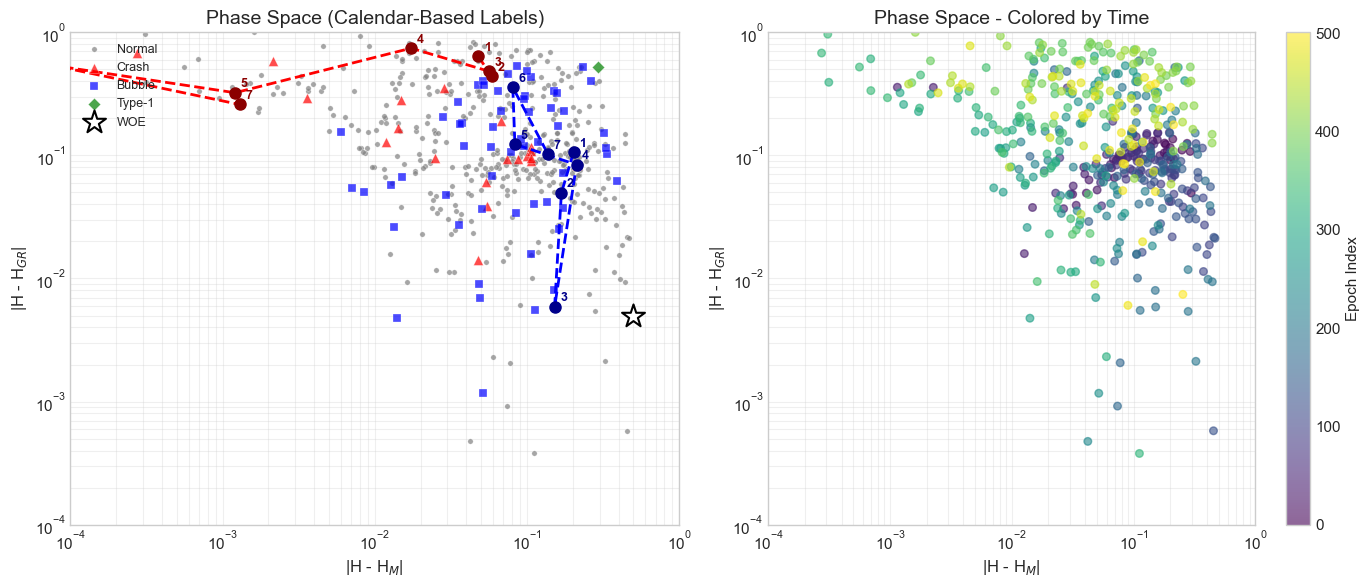

In [14]:
from modules.plot_code import plot_phase_space
from modules.eigen import get_transition_sequence

plot_phase_space(results, get_transition_sequence)


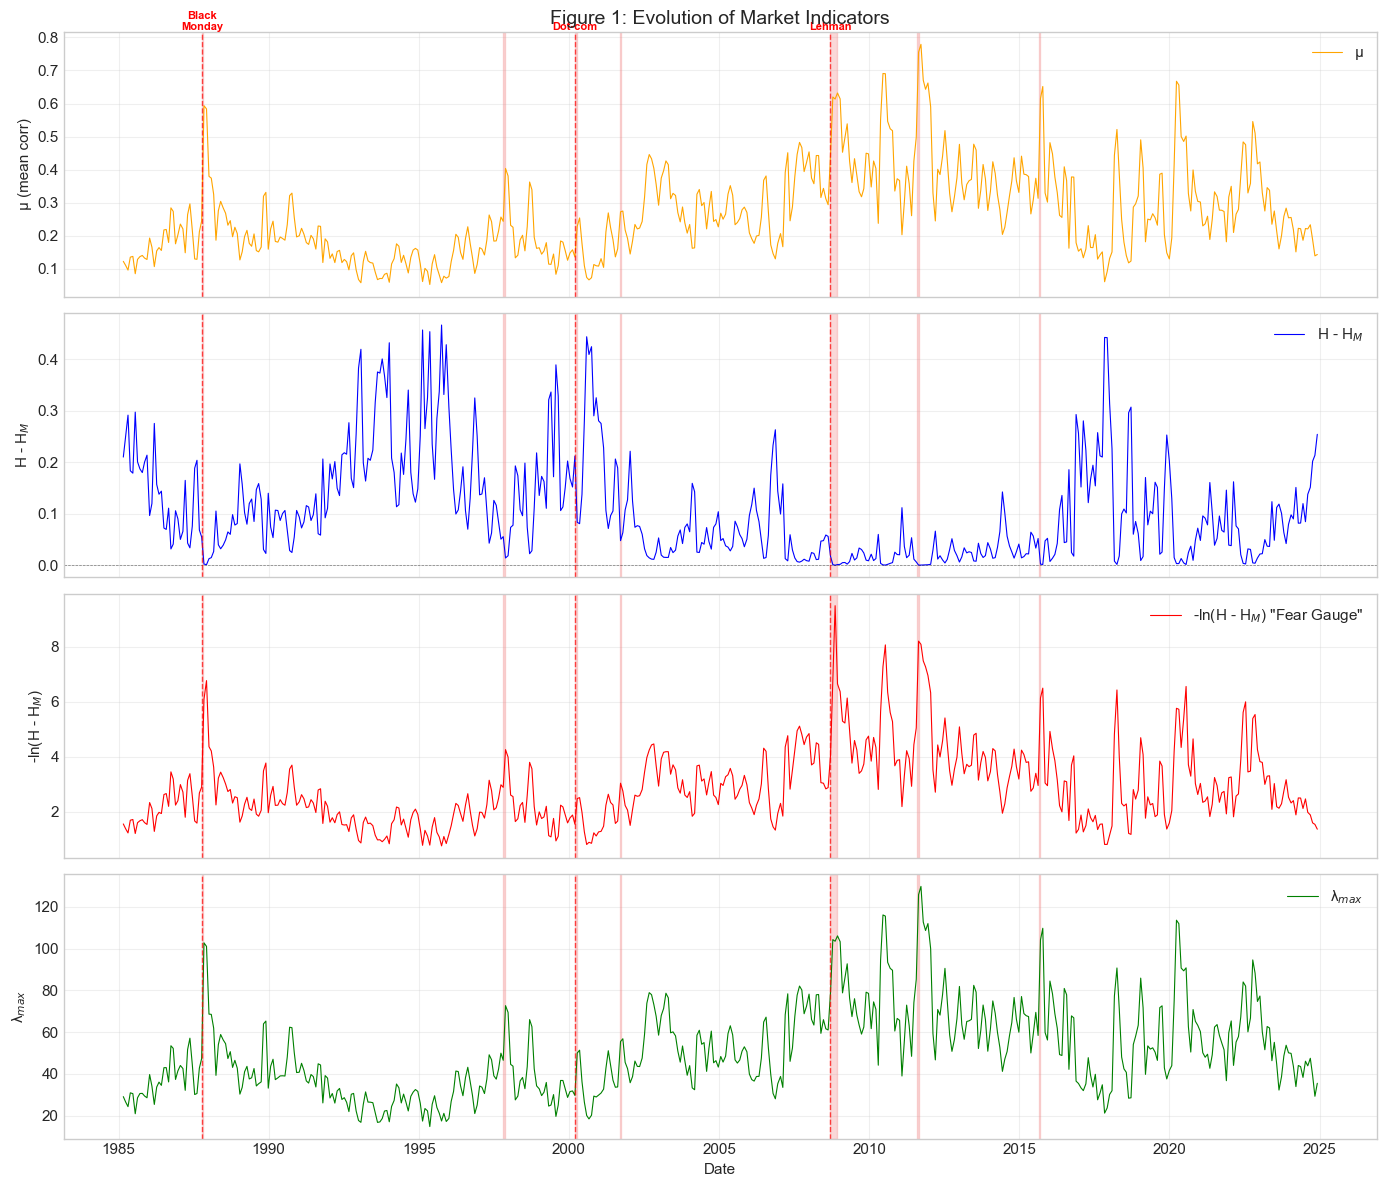

In [15]:
from modules.config import CRISIS_PERIODS, MAJOR_CRASHES
from modules.plot_code import plot_market_indicators

plot_market_indicators(
    results,
    crisis_periods=CRISIS_PERIODS,
    major_crashes=MAJOR_CRASHES
)


Scaling fit: (H - H_M) ~ 0.785 * exp(-9.85 * μ)
Paper values: α ≈ 0.85, β ≈ 10.22


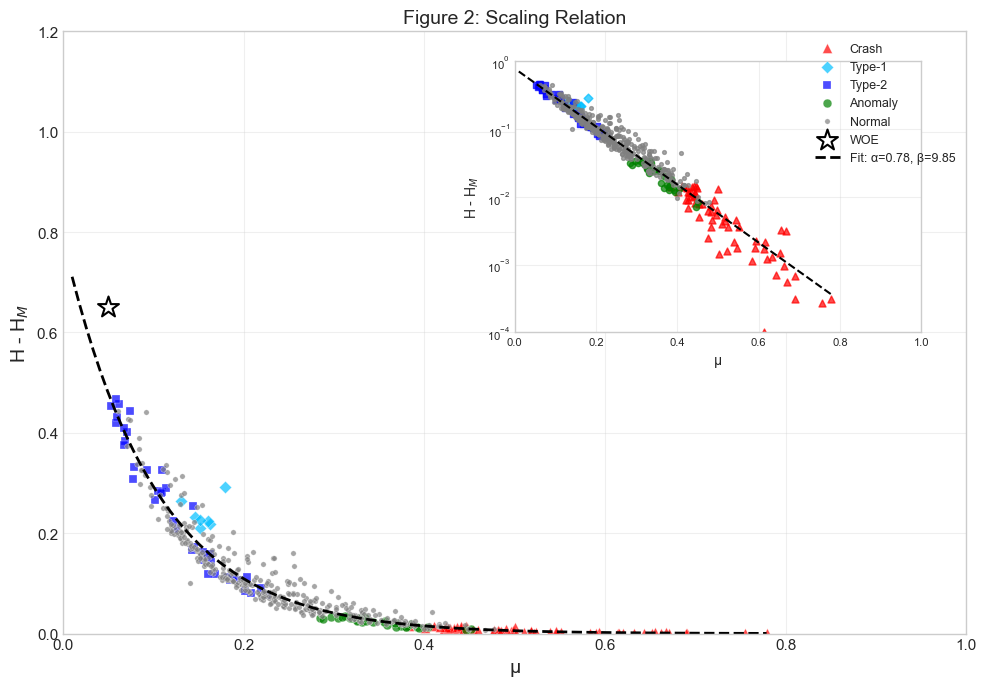

In [16]:
from modules.eigen import assign_phase_regimes, fit_scaling_relation
from modules.plot_code import plot_scaling_relation

results_plot = assign_phase_regimes(results)
fit = fit_scaling_relation(results_plot, verbose=True)
plot_scaling_relation(results_plot, fit=fit)


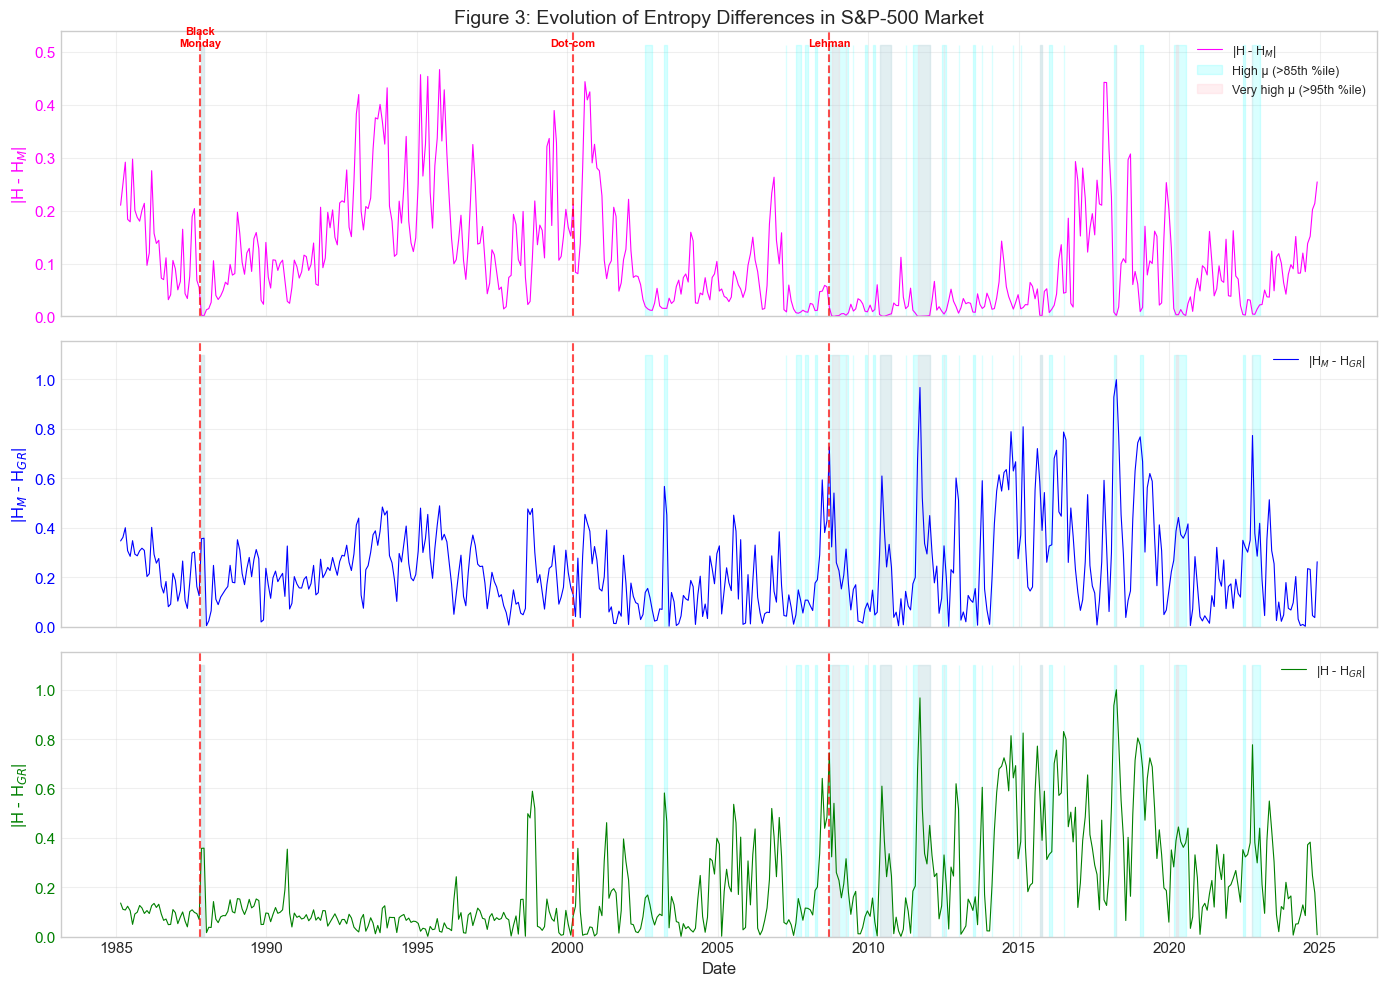

In [17]:
from modules.plot_code import plot_entropy_differences

plot_entropy_differences(
    results,
    crash_dates=MAJOR_CRASHES,
    high_mu_q=0.85,
    very_high_mu_q=0.95)


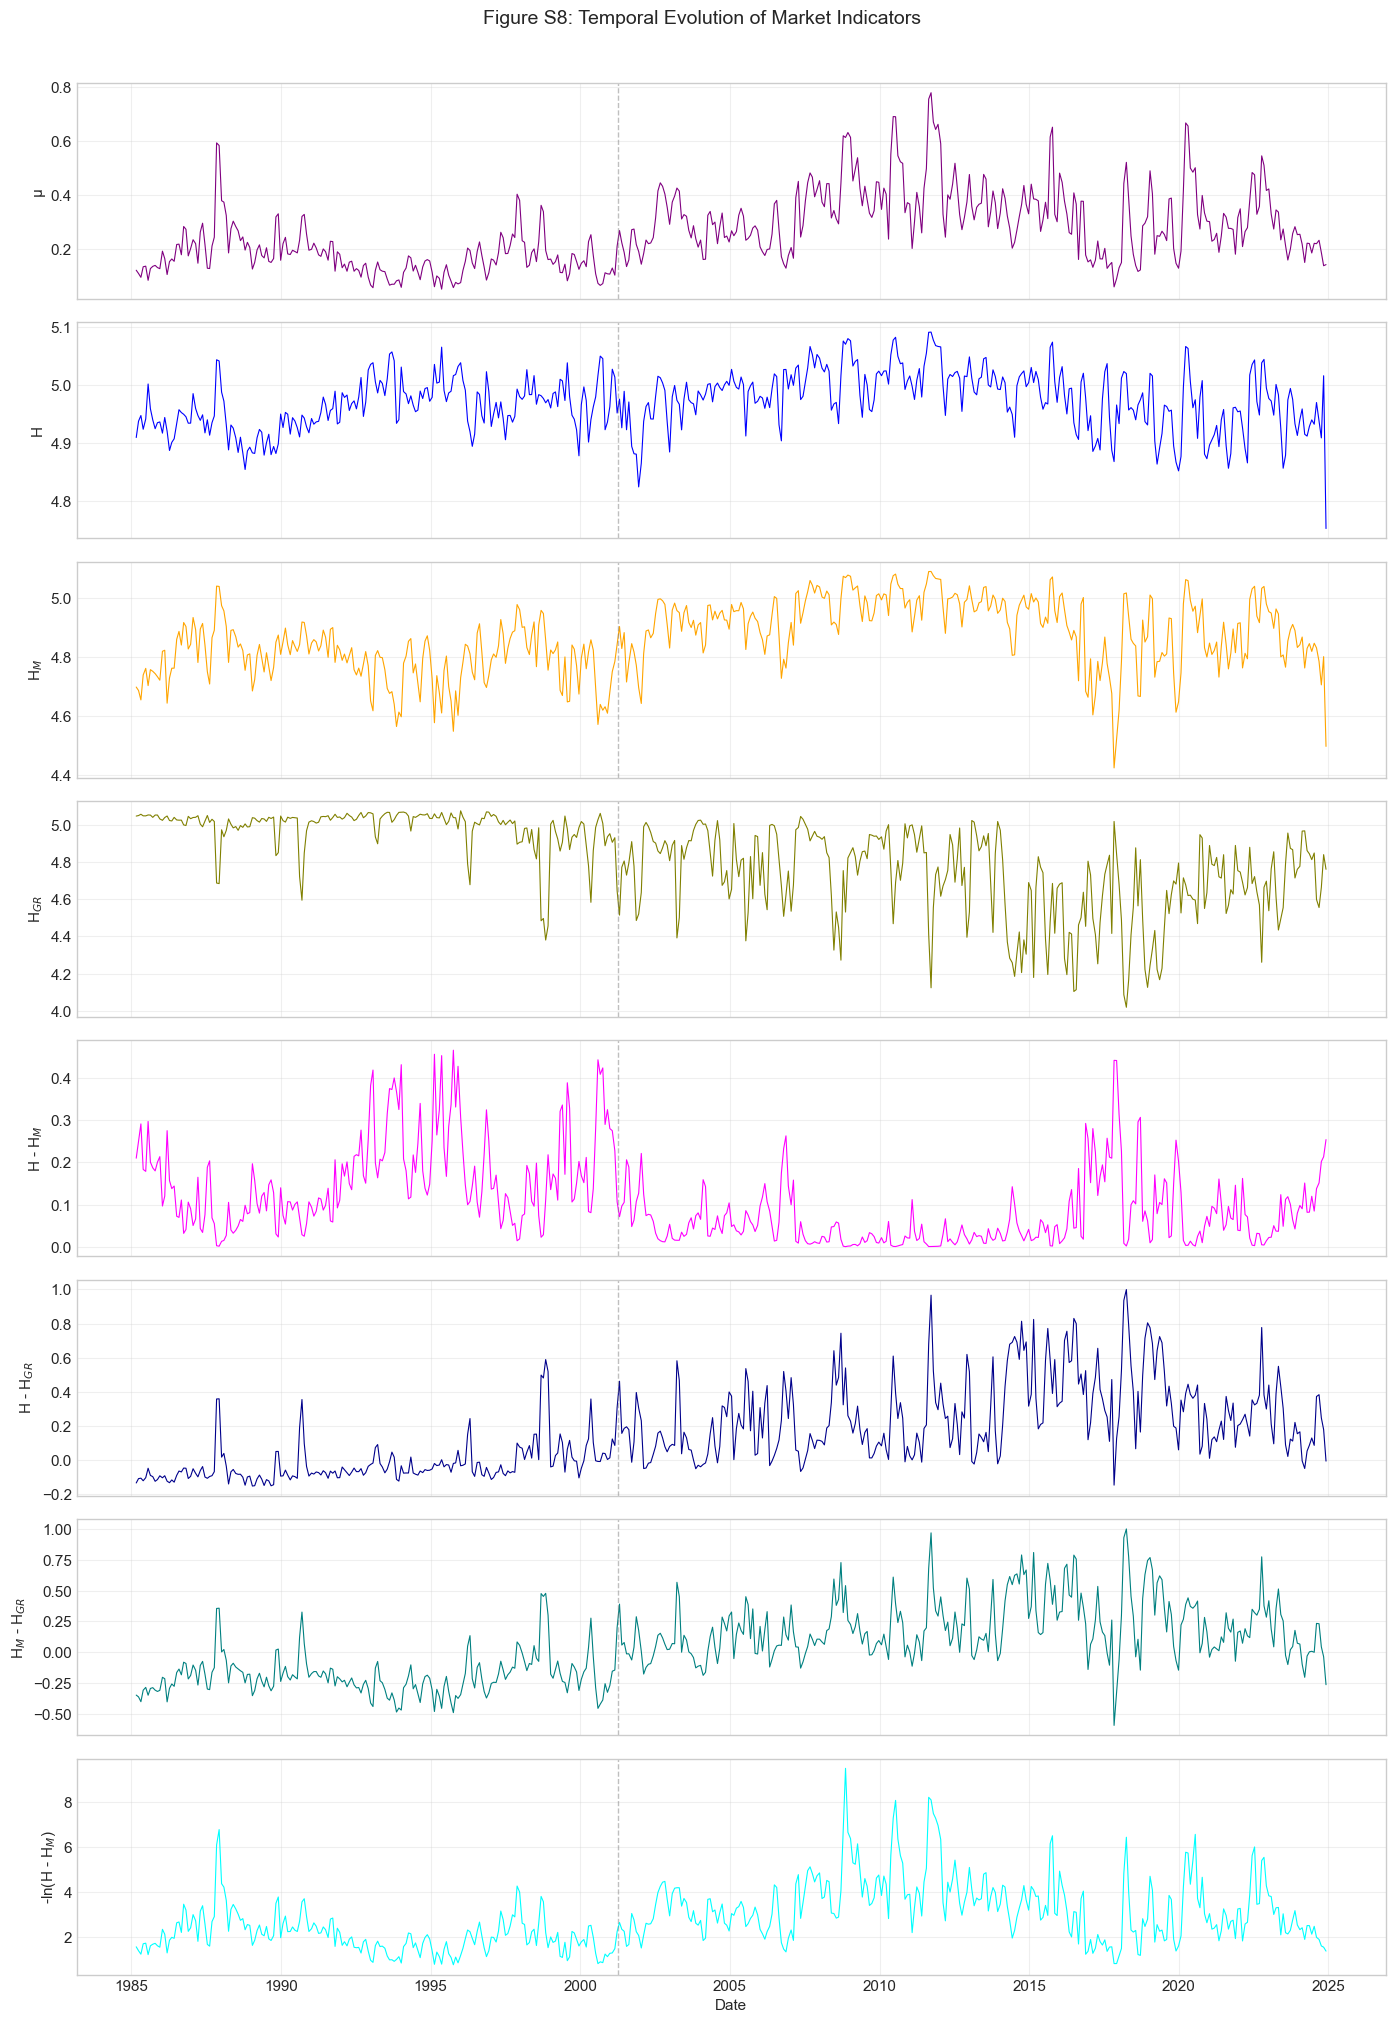

In [18]:

from modules.plot_code import plot_full_temporal_evolution

plot_full_temporal_evolution(results)


Phase-based regime distribution:
phase_regime
Normal     361
Crash       61
Type-2      42
Anomaly     31
Type-1       7
Name: count, dtype: int64


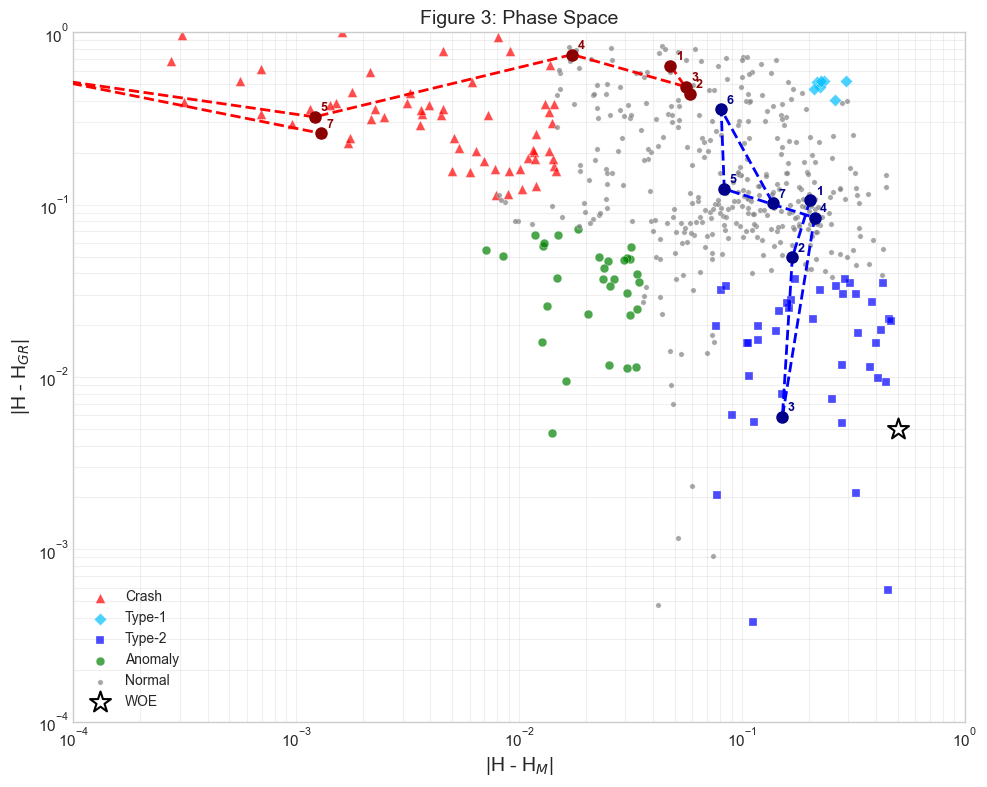

In [19]:
from modules.eigen import assign_phase_regimes_exact, get_transition_sequence
from modules.plot_code import plot_phase_space_exact
from modules.config import PHASE_MARKERS, PHASE_WOE_POINT, PHASE_TRANSITIONS, PHASE_PLOT_LIMITS

results_plot = assign_phase_regimes_exact(results)

print("Phase-based regime distribution:")
print(results_plot['phase_regime'].value_counts())

plot_phase_space_exact(
    results_plot,
    markers=PHASE_MARKERS,
    woe_point=PHASE_WOE_POINT,
    transitions=PHASE_TRANSITIONS,
    get_transition_sequence_fn=get_transition_sequence,
    legend_loc=PHASE_PLOT_LIMITS["legend_loc"],
    xlim=PHASE_PLOT_LIMITS["xlim"],
    ylim=PHASE_PLOT_LIMITS["ylim"],
)


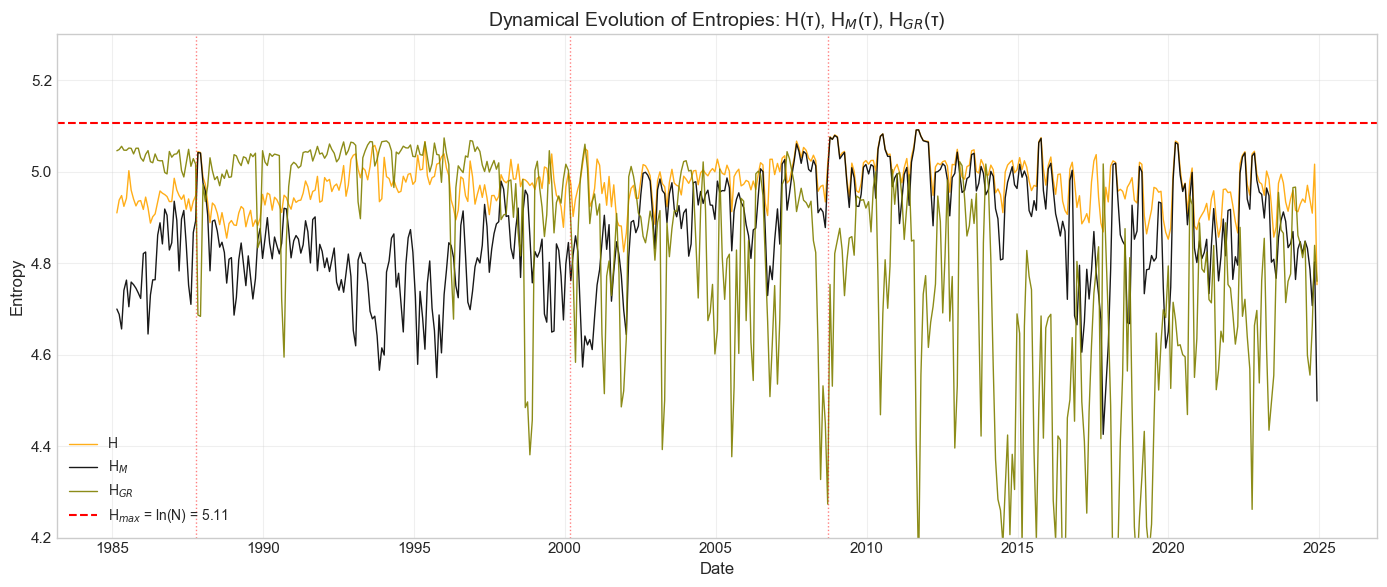

In [20]:
from modules.plot_code import plot_entropy_evolution

plot_entropy_evolution(results, MAJOR_CRASHES, ylim=(4.2, 5.3))


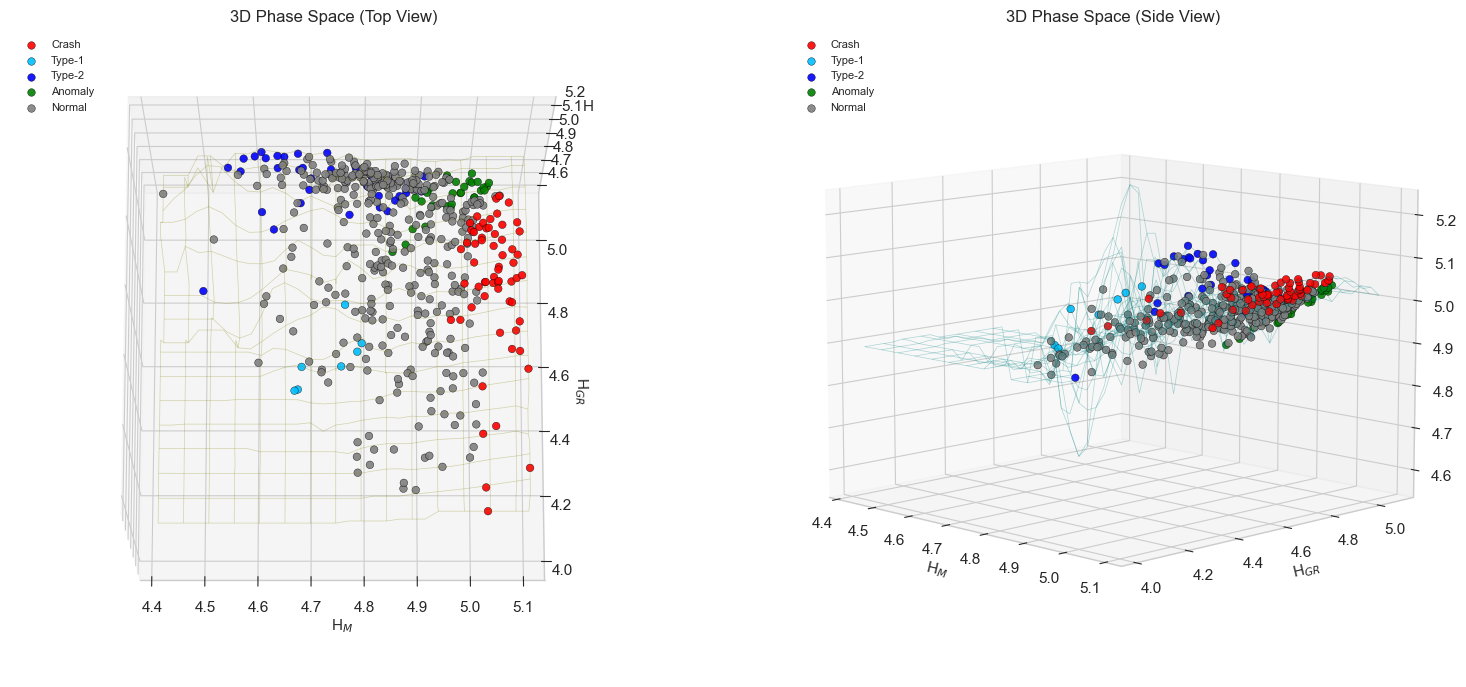

In [21]:
from modules.config import COLORS_3D
from modules.plot_code import plot_3d_phase_space_wireframe

plot_3d_phase_space_wireframe(results_plot, COLORS_3D, grid_n=30)


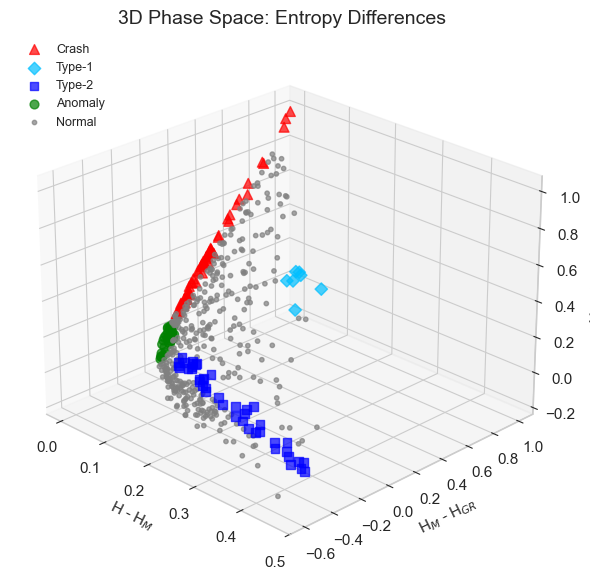

In [22]:
from modules.eigen import assign_phase_regimes   # the one you already created
from modules.config import MARKERS_3D_DIFFS
from modules.plot_code import plot_3d_entropy_differences

results_plot = assign_phase_regimes(results)
plot_3d_entropy_differences(results_plot, MARKERS_3D_DIFFS)


event_name  event_date      transition_type  \
0        Black Monday  1987-10-19     CRASH TRANSITION   
1        Asian Crisis  1997-10-27   ANOMALY TRANSITION   
2       Dot-com Crash  2000-03-10      TYPE TRANSITION   
3                9/11  2001-09-11  NO CLEAR TRANSITION   
4              Lehman  2008-09-15     CRASH TRANSITION   
5         Flash Crash  2010-05-06     CRASH TRANSITION   
6            Aug 2011  2011-08-08     CRASH TRANSITION   
7  China Black Monday  2015-08-24     CRASH TRANSITION   
8               COVID  2020-02-20     CRASH TRANSITION   

                                            sequence  event_abs_H_minus_HM  \
0  Normal → Normal → Normal → Normal → Crash → Cr...              0.054810   
1  Normal → Normal → Normal → Normal → Normal → A...              0.055558   
2  Normal → Type-2 → Type-2 → Normal → Normal → N...              0.212064   
3  Normal → Normal → Normal → Normal → Normal → N...              0.047756   
4  Normal → Normal → Normal → Crash → Crash → Cra...              0.017347   
5  Crash → Anomaly → Normal → Crash → Crash → Cra...              0.003593   
6  Normal → Normal → Crash → Crash → Crash → Cras...              0.006406   
7  Normal → Normal → Normal → Normal → Crash → Cr...              0.051957   
8  Normal → Normal → Normal → Crash → Crash → Cra...              0.014770   

   event_abs_H_minus_HGR  
0               0.069511  
1               0.073147  
2               0.084119  
3               0.014167  
4               0.743288  
5               0.291709  
6               0.204882  
7               0.771312  
8               0.282092

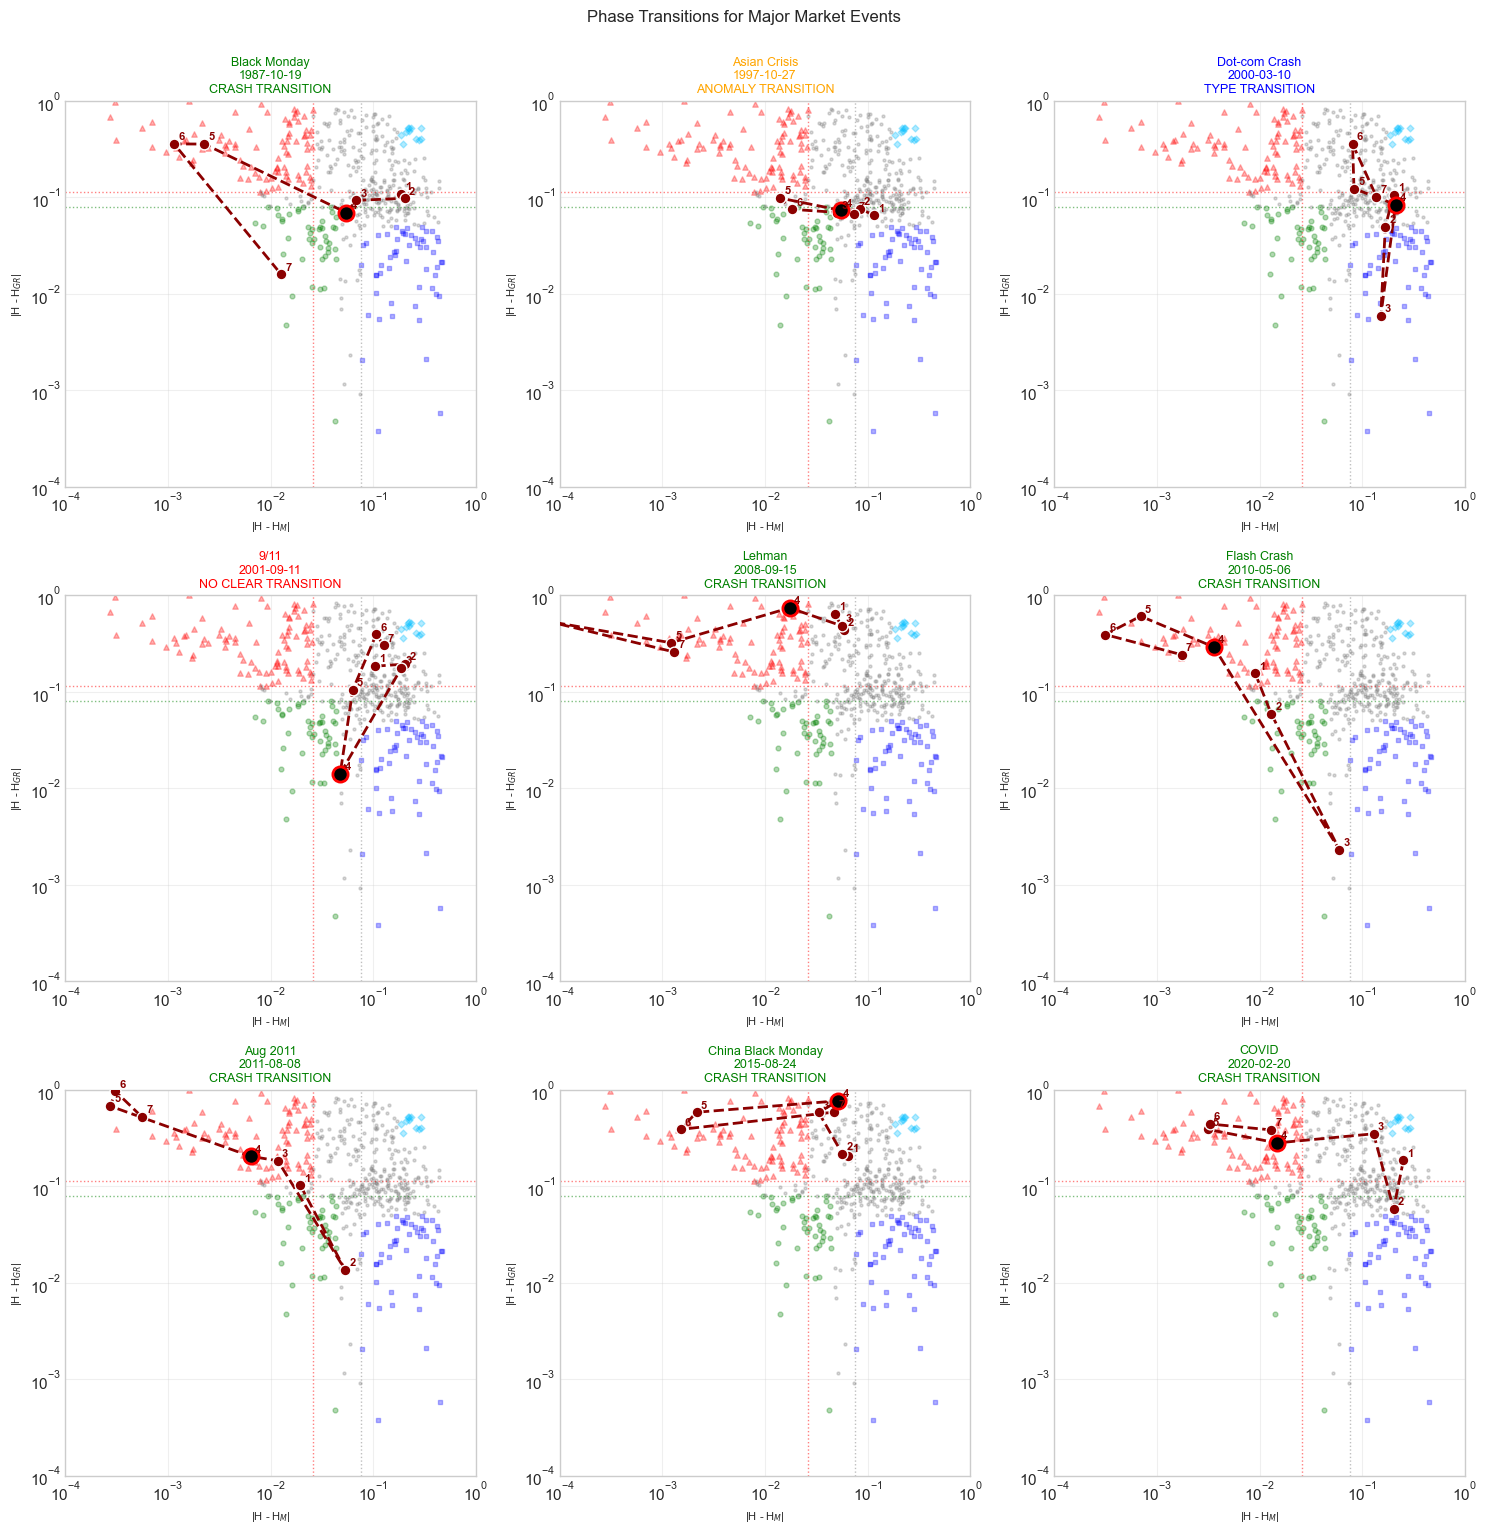

In [23]:
from modules.eigen import assign_phase_regimes_quantiles, summarize_event_transitions
from modules.plot_code import plot_event_transition_grid
from modules.config import CRASH_EVENTS


results_plot, thr = assign_phase_regimes_quantiles(results)

summary = summarize_event_transitions(results_plot, CRASH_EVENTS)
display(summary)

plot_event_transition_grid(results_plot, CRASH_EVENTS, thr, ncols=3, figsize=(15, 15))


In [24]:
from modules.plot_code import report_crash_regime_detections
out = report_crash_regime_detections(results, CRASH_EVENTS, window_radius=2)


PHASE SPACE 'CRASH' REGIME DETECTIONS
(LOW |H-H_M| AND HIGH |H-H_GR| simultaneously)

Total epochs classified as 'Crash': 90 out of 502

Crash periods detected:
          date  abs_H_minus_HM  abs_H_minus_HGR
34  1987-11-06        0.002267         0.357147
35  1987-12-07        0.001147         0.358109
171 1998-09-10        0.022369         0.497606
220 2002-08-06        0.018808         0.156732
221 2002-09-04        0.014291         0.168369
222 2002-10-02        0.011893         0.128553
228 2003-03-26        0.015203         0.581548
229 2003-04-24        0.015204         0.466057
231 2003-06-20        0.024489         0.162040
242 2004-05-05        0.024772         0.152818
284 2007-09-06        0.006004         0.154002
287 2007-11-30        0.008939         0.115499
288 2007-12-31        0.007857         0.114307
291 2008-03-28        0.010991         0.186821
292 2008-04-25        0.011629         0.200849
297 2008-09-17        0.017347         0.743288
298 2008-10-15        0

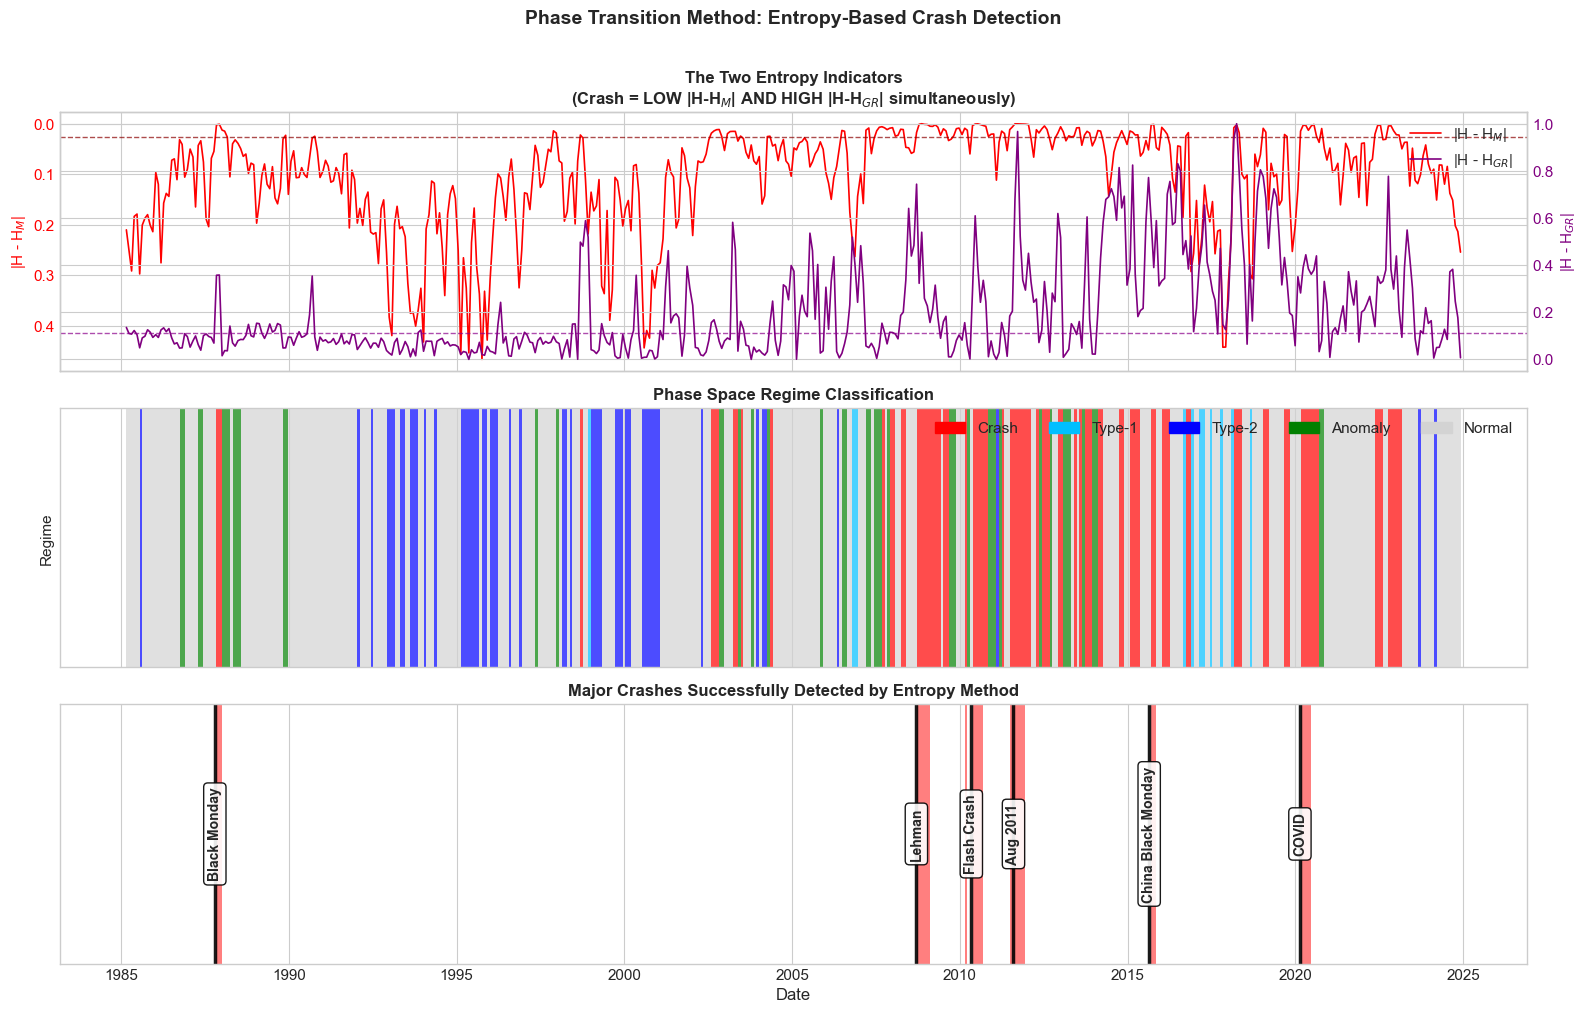

0

In [25]:
from modules.plot_code import plot_entropy_crash_detection_panels
#get detected crashes from previous cell
WELL_DETECTED_CRASHES = out["well_detected_crashes"]

plot_entropy_crash_detection_panels(results_plot, thr, WELL_DETECTED_CRASHES, days_threshold=120)


---
## Step 7: Summary Statistics and Validation

In [26]:
# Summary statistics by regime
print("="*70)
print("SUMMARY STATISTICS BY REGIME")
print("="*70)

for regime in ['normal', 'crash', 'bubble', 'type-1']:
    subset = results[results['regime'] == regime]
    if len(subset) > 0:
        print(f"\n{regime.upper()} (n={len(subset)}):")
        print(f"  H:          mean={subset['H'].mean():.4f}, std={subset['H'].std():.4f}")
        print(f"  H_M:        mean={subset['H_M'].mean():.4f}, std={subset['H_M'].std():.4f}")
        print(f"  H_GR:       mean={subset['H_GR'].mean():.4f}, std={subset['H_GR'].std():.4f}")
        print(f"  |H - H_M|:  mean={subset['abs_H_minus_HM'].mean():.4f}")
        print(f"  |H - H_GR|: mean={subset['abs_H_minus_HGR'].mean():.4f}")
        print(f"  μ (corr):   mean={subset['mu'].mean():.4f}, std={subset['mu'].std():.4f}")

SUMMARY STATISTICS BY REGIME

NORMAL (n=417):
  H:          mean=4.9711, std=0.0503
  H_M:        mean=4.8623, std=0.1218
  H_GR:       mean=4.8192, std=0.2453
  |H - H_M|:  mean=0.1089
  |H - H_GR|: mean=0.2057
  μ (corr):   mean=0.2642, std=0.1364

CRASH (n=24):
  H:          mean=4.9732, std=0.0612
  H_M:        mean=4.9180, std=0.1019
  H_GR:       mean=4.8158, std=0.2221
  |H - H_M|:  mean=0.0552
  |H - H_GR|: mean=0.2250
  μ (corr):   mean=0.3448, std=0.1768

BUBBLE (n=60):
  H:          mean=4.9732, std=0.0462
  H_M:        mean=4.8662, std=0.0987
  H_GR:       mean=4.8243, std=0.1710
  |H - H_M|:  mean=0.1069
  |H - H_GR|: mean=0.1650
  μ (corr):   mean=0.2400, std=0.0905

TYPE-1 (n=1):
  H:          mean=4.9781, std=nan
  H_M:        mean=4.6852, std=nan
  H_GR:       mean=4.4543, std=nan
  |H - H_M|:  mean=0.2928
  |H - H_GR|: mean=0.5237
  μ (corr):   mean=0.1791, std=nan


In [27]:
# Validate against paper's key findings
print("="*70)
print("VALIDATION AGAINST PAPER'S FINDINGS")
print("="*70)

print("\n1. During CRASHES:")
print("   Paper says: H ≈ H_M (so |H - H_M| → 0)")
crash_data = results[results['regime'] == 'crash']
if len(crash_data) > 0:
    print(f"   Our result: |H - H_M| = {crash_data['abs_H_minus_HM'].mean():.4f}")

print("\n2. Maximum entropy should approach ln(N):")
print(f"   H_max = ln({N_STOCKS}) = {np.log(N_STOCKS):.4f}")
print(f"   Max H observed: {results['H'].max():.4f}")

print("\n3. Scaling relation (H - H_M) ~ exp(-β*μ):")
print("   Paper finds: α ≈ 0.85, β ≈ 10.22")
print("   (Check the fit in the scaling plot above)")

print("\n4. Correlation during crashes vs normal:")
normal_mu = results[results['regime'] == 'normal']['mu'].mean()
if len(crash_data) > 0:
    crash_mu = crash_data['mu'].mean()
    print(f"   Normal: μ = {normal_mu:.4f}")
    print(f"   Crash:  μ = {crash_mu:.4f}")
    print(f"   (Crashes should have higher correlation)")

VALIDATION AGAINST PAPER'S FINDINGS

1. During CRASHES:
   Paper says: H ≈ H_M (so |H - H_M| → 0)
   Our result: |H - H_M| = 0.0552

2. Maximum entropy should approach ln(N):
   H_max = ln(165) = 5.1059
   Max H observed: 5.0915

3. Scaling relation (H - H_M) ~ exp(-β*μ):
   Paper finds: α ≈ 0.85, β ≈ 10.22
   (Check the fit in the scaling plot above)

4. Correlation during crashes vs normal:
   Normal: μ = 0.2642
   Crash:  μ = 0.3448
   (Crashes should have higher correlation)
